# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [1]:
# Import numpy and pandas
import numpy as np
import pandas as pd


# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [2]:
# Run this code:

sensor = pd.read_csv('../sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [3]:
sensor.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [4]:
sensor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751 entries, 0 to 1750
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   attitude.roll       1751 non-null   float64
 1   attitude.pitch      1751 non-null   float64
 2   attitude.yaw        1751 non-null   float64
 3   gravity.x           1751 non-null   float64
 4   gravity.y           1751 non-null   float64
 5   gravity.z           1751 non-null   float64
 6   rotationRate.x      1751 non-null   float64
 7   rotationRate.y      1751 non-null   float64
 8   rotationRate.z      1751 non-null   float64
 9   userAcceleration.x  1751 non-null   float64
 10  userAcceleration.y  1751 non-null   float64
 11  userAcceleration.z  1751 non-null   float64
dtypes: float64(12)
memory usage: 164.3 KB


How many rows and columns are in our data?

In [5]:
# There are 1751 rows and 12 columns
sensor.shape

(1751, 12)

To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [6]:
# Create the sensor time
sensor_t=pd.date_range("1/1/2018 00:00:00", "1/1/2018 00:29:10", periods=sensor.shape[0], freq=None)
sensor_t.freq=pd.infer_freq(sensor_t)
#sensor_t.freq=sensor_t.inferred_freq
# Add this column 
sensor["time"]=sensor_t
sensor_t

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:00:01',
               '2018-01-01 00:00:02', '2018-01-01 00:00:03',
               '2018-01-01 00:00:04', '2018-01-01 00:00:05',
               '2018-01-01 00:00:06', '2018-01-01 00:00:07',
               '2018-01-01 00:00:08', '2018-01-01 00:00:09',
               ...
               '2018-01-01 00:29:01', '2018-01-01 00:29:02',
               '2018-01-01 00:29:03', '2018-01-01 00:29:04',
               '2018-01-01 00:29:05', '2018-01-01 00:29:06',
               '2018-01-01 00:29:07', '2018-01-01 00:29:08',
               '2018-01-01 00:29:09', '2018-01-01 00:29:10'],
              dtype='datetime64[ns]', length=1751, freq='S')

Assign the time series index to the dataframe's index.

In [7]:
# Define this column as index
sensor.index = sensor["time"]
# I need to put the frequency again. I dont know why it dissapeared
sensor.index.freq = pd.infer_freq(sensor_t)
sensor.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:00:01',
               '2018-01-01 00:00:02', '2018-01-01 00:00:03',
               '2018-01-01 00:00:04', '2018-01-01 00:00:05',
               '2018-01-01 00:00:06', '2018-01-01 00:00:07',
               '2018-01-01 00:00:08', '2018-01-01 00:00:09',
               ...
               '2018-01-01 00:29:01', '2018-01-01 00:29:02',
               '2018-01-01 00:29:03', '2018-01-01 00:29:04',
               '2018-01-01 00:29:05', '2018-01-01 00:29:06',
               '2018-01-01 00:29:07', '2018-01-01 00:29:08',
               '2018-01-01 00:29:09', '2018-01-01 00:29:10'],
              dtype='datetime64[ns]', name='time', length=1751, freq='S')

Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

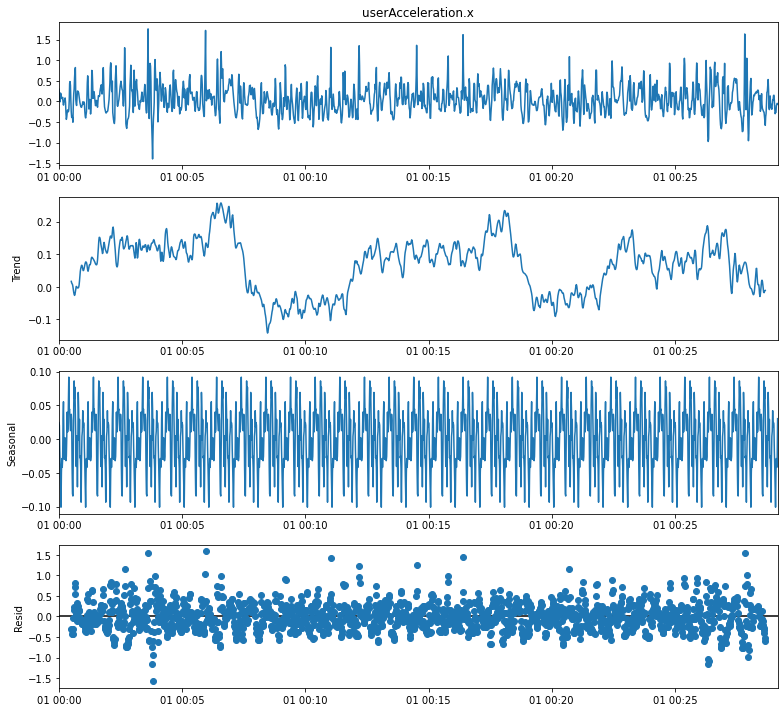

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize'] = 11, 10
res = seasonal_decompose(sensor["userAcceleration.x"], model="additive",period=60)
res.plot();

Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

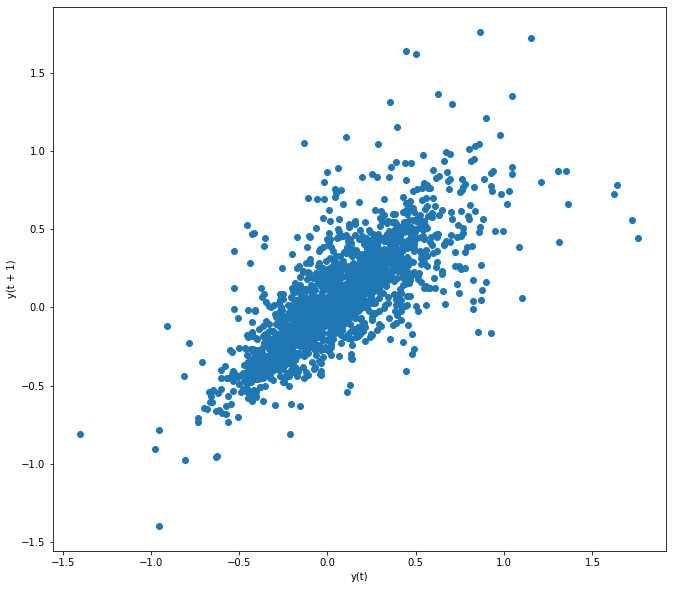

In [9]:
pd.plotting.lag_plot(sensor["userAcceleration.x"], lag=1)


Create a lag plot for `rotationRate.x`

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

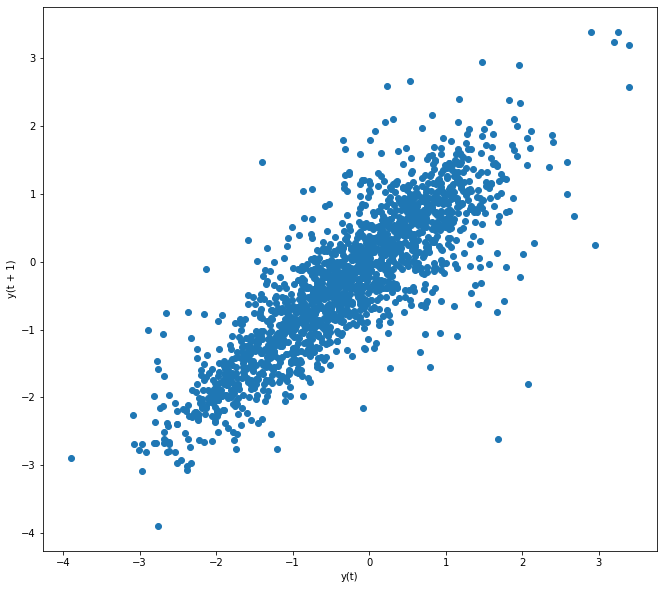

In [10]:
pd.plotting.lag_plot(sensor["rotationRate.x"], lag=1)

What are your conclusions from both visualizations?

In [11]:
# I used a lag 1 (first-order lag plot). A linear shape to the plot suggests that autocorrelation is present
# In the userAcceleration.x and rotationRate.x cases, there seems to be some autocorrelation,
# but the first one shows more dispersion in the upper-right corner. There are some outliers as well, but
# deifinitely the data is not random.

The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

In [12]:
# p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.  
    
from statsmodels.tsa.stattools import adfuller
alpha = 0.05
result_ua = adfuller(sensor["userAcceleration.x"]) 
pval = result_ua[1]
print("Augmented Dickey Fuller test on userAcceleration.x")
print(f"p-value={pval}")
if pval<alpha:
    print("We may reject H0: The data is stationary")
else:
    print("We cannot reject H0: The data is non-stationary")
    
print("\n")

result_rr = adfuller(sensor["rotationRate.x"]) 
pval = result_rr[1]
print("Augmented Dickey Fuller test on rotationRate.x")
print(f"p-value={pval}")
if pval<alpha:
    print("We may reject H0: The data is stationary")
else:
    print("We cannot reject H0: The data is non-stationary")
    

Augmented Dickey Fuller test on userAcceleration.x
p-value=2.823439483037483e-30
We may reject H0: The data is stationary


Augmented Dickey Fuller test on rotationRate.x
p-value=6.320230335912249e-06
We may reject H0: The data is stationary


What are your conclusions from this test?

In [13]:
# As stated with the prints, a p-value of the tests indicates that the tested data is stationary
# and hence there is no trend with time.

Finally, we'll create an ARMA model for `userAcceleration.x`. Load the `ARMA` function from `statsmodels`. The order of the model is (2, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

In [14]:
# Deprecated since version 0.12: Use statsmodels.tsa.arima.model.ARIMA instead
# Deprecated since version 0.12: Use statsmodels.tsa.arima.model.ARIMA instead
#
# Autoregressive integrated moving average (ARIMA) model is a generalization 
# of an autoregressive moving average (ARMA) model
from statsmodels.tsa.arima.model import ARIMA

val = sensor["userAcceleration.x"]

train = val[:-10]
test = val[-10:]

model_fit=ARIMA(train, order=(2,0, 1)).fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:     userAcceleration.x   No. Observations:                 1741
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 373.401
Date:                Tue, 24 Nov 2020   AIC                           -736.803
Time:                        18:59:59   BIC                           -709.492
Sample:                    01-01-2018   HQIC                          -726.704
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0637      0.016      3.994      0.000       0.032       0.095
ar.L1          0.9882      0.036     27.630      0.000       0.918       1.058
ar.L2         -0.3788      0.033    -11.637      0.0

To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [15]:
from statsmodels.tools import eval_measures
predict_test = model_fit.predict(test.index[0], test.index[-1], dynamic = True)
print("Root mean squered error =",eval_measures.rmse(predict_test,test))

Root mean squered error = 0.2252916044980741
